# QMLHEP Project Preparation


***

In [1]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

file = 'QIS_EXAM_200Events.npz'

font  = {'family': 'serif',
         'weight': 'normal',
         'size': 11}

## Data Load and Visualization
Visualize the distribution of each feature

In [2]:
with np.load(file, allow_pickle=True) as data:
    train = data['training_input'].item()
    test  = data['test_input'].item()
    
X = np.vstack((train['0'], 
               train['1']))
y = np.hstack((np.zeros(len(train['0']), 
                        dtype='int'), 
               np.ones(len(train['1']), 
                       dtype='int')))

X_test = np.vstack((test['0'], 
                    test['1']))
y_test = np.hstack((np.zeros(len(test['0']), 
                             dtype='int'), 
                    np.ones(len(test['1']), 
                            dtype='int')))

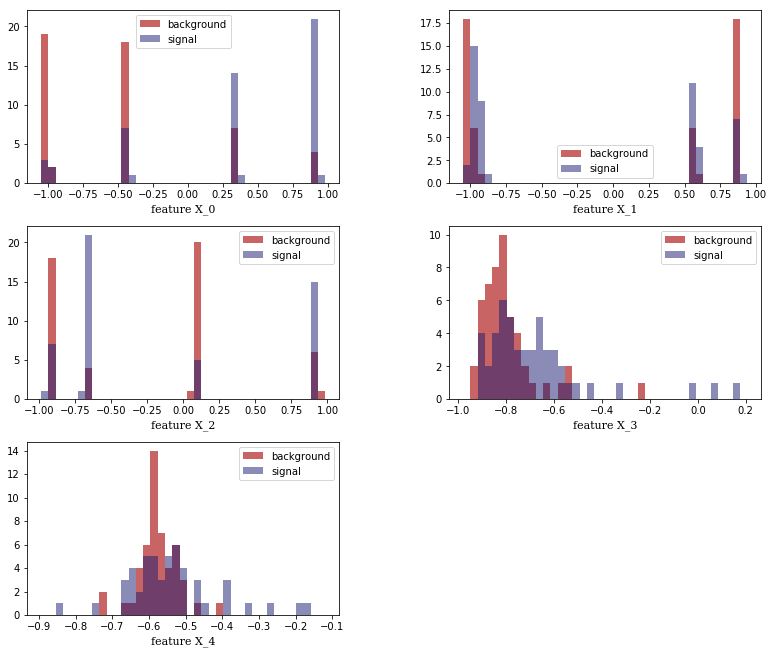

In [3]:
delta = .05
n = 50
_, features = X.shape

plt.figure(figsize=(12,10))

for i in range(features):
    lims = (min(X[:,i]) - delta, max(X[:,i]) + delta)

    plt.subplot('32{}'.format(i+1))
    plt.hist(X[:n,i],
             bins=np.linspace(*lims, 40),
             color='firebrick',
             alpha=.7,
             label='background');
    
    plt.hist(X[n:,i],
             bins=np.linspace(*lims, 40),
             alpha=.5,
             color='midnightblue',
             label='signal');
    
    plt.legend();
    plt.xlabel('feature X_{}'.format(i), 
              fontdict=font)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

## Boosting Decision Tree


In [96]:
bdt = xgb.XGBClassifier(learning_rate=.3,
                        max_depth=3, 
                        n_estimators=10, 
                        gamma=.1, 
                        reg_lamda=.3, 
                        min_child_weight=5)

bdt.fit(X, y, 
        early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_test, y_test)], 
        verbose=3);

[0]	validation_0-auc:0.79000
Will train until validation_0-auc hasn't improved in 10 rounds.
[3]	validation_0-auc:0.82740
[6]	validation_0-auc:0.82400
[9]	validation_0-auc:0.82960


## Visualize Classifier Output

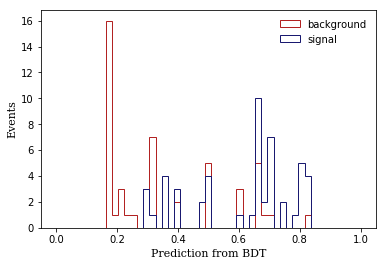

In [97]:
N = 50
clf = bdt
b_pred = clf.predict_proba(X_test[:N])[:,1]
s_pred = clf.predict_proba(X_test[N:])[:,1]

plt.hist(b_pred,
         bins=np.linspace(0,1,50),
         histtype='step',
         color='firebrick',
         label='background');

plt.hist(s_pred,
         bins=np.linspace(0,1,50),
         histtype='step',
         color='midnightblue',
         label='signal');



plt.xlabel('Prediction from BDT', 
           fontdict=font);
plt.ylabel('Events', 
           fontdict=font);

plt.legend(frameon=False);

## ROC - AUC - Accuracy


 Boosting Decision Tree 
  accuracy: 0.72 
  AUC:      0.834


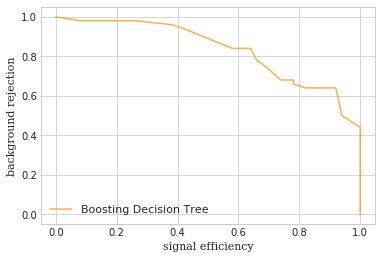

In [98]:
color = { 'Boosting Decision Tree': 'darkorange'}

classifiers = [(bdt, 'Boosting Decision Tree')]

with plt.style.context('seaborn-whitegrid'):
    
    for i, (clf, name) in enumerate(classifiers, 0):
        
        accuracy    = clf.score(X_test, y_test)
        y_pred      = clf.predict_proba(X_test)[:,1]
        
        FPR, TPR, _ = roc_curve(y, y_pred)
        AUC         = roc_auc_score(y, y_pred)
        
        print('\n {} \n  accuracy: {} \n  AUC:      {}'
              .format(name, accuracy, np.round(AUC,3)))
        
        plt.plot(TPR, 1-FPR, 
                 c=color[name], alpha=.7, 
                 label=name)
        
    plt.legend(loc='lower left', 
               fontsize=11, )
    
    plt.xlabel('signal efficiency', 
               fontdict=font)
    plt.ylabel('background rejection', 
               fontdict=font)